Implements Deep Learning using tensorflow:
* Adapted from Coursera course "Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization"
* The model is LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
* The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes.
* Xavier initialization for weights and zero initialization for biases

In [452]:
# Load the library with the iris dataset
from sklearn.datasets import load_iris

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

# Common functions

In [453]:
def random_mini_batches(X_train, Y_train, minibatch_size, seed):
    """
    Split X_train and Y_train into mini-batches
    Input
        X_train        : training set, of shape (input size = n_x, number of training examples = m)
        Y_train        : test set, of shape (output size = n_y, number of training examples = m)
        minibatch_size : size of a minibatch
        seed           : when the number of training examples is not a multiple of minibatch_size, 
                         we add random samples from the training set to the last minibatch to ensure the last 
                         minibatch is also of size minibatch_size
    Output
        minibatches    : [(minibatch_X1, minibatch_Y1), (minibatch_X2, minibatch_Y2), ...]
    """
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    
    minibatches = []
    for ind in range(int(m/minibatch_size)):
        minibatch_X1 = X_train[:, ind*minibatch_size:(ind+1)*minibatch_size]
        minibatch_Y1 = Y_train[:, ind*minibatch_size:(ind+1)*minibatch_size]
        minibatches.append((minibatch_X1, minibatch_Y1))

    # If dataset size is not a multiple of minibatch_size, replicate extra data at random
    if m % minibatch_size > 0:
        minibatch_X1_part = X_train[:, (ind+1)*minibatch_size:]
        minibatch_Y1_part = Y_train[:, (ind+1)*minibatch_size:]
#         print("minibatch_X1_part.shape = " + str(minibatch_X1_part.shape))
#         print("minibatch_Y1_part.shape = " + str(minibatch_Y1_part.shape))
        
        extra_data_num = minibatch_size - (m % minibatch_size)
#         print("extra_data_num = " + str(extra_data_num))
        np.random.seed(seed)
        perm = np.random.permutation(X_train.T).T # permutate the columns of X_train
        extra_data = perm[:, :extra_data_num]
#         print("perm = " + str(perm))
#         print("perm.shape = " + str(perm.shape))
#         print("extra_data = " + str(extra_data))
#         print("extra_data.shape = " + str(extra_data.shape))
        
        minibatch_X1 = np.concatenate((minibatch_X1_part, extra_data), axis = 1)
#         print("minibatch_X1.shape = " + str(minibatch_X1.shape))
        
        np.random.seed(seed)
        perm_y = np.random.permutation(Y_train.T).T # permutate the columns of Y_train
        extra_data_y = perm_y[:, :extra_data_num]
        minibatch_Y1 = np.concatenate((minibatch_Y1_part, extra_data_y), axis = 1)
#         print("minibatch_Y1.shape = " + str(minibatch_Y1.shape))
        
        minibatches.append((minibatch_X1, minibatch_Y1))
                                      
    return minibatches

def convert_to_one_hot(x, n_c):
    """
    Converts numpy array to one hot numpy array
    Input 
        x   : numpy array of size m, where m is no. of examples. e.g. x = array([0, 0, 1, 2, 2]) where m = 5
              Here, x.shape = (5,)
        n_c : number of classes, in the above example, n_c = 3 
    Output
        one_hot: numpy array of size (n_c, m). In the above example, one_hot = array([[1., 1., 0., 0., 0.],
                                                                                      [0., 0., 1., 0., 0.],
                                                                                      [0., 0., 0., 1., 1.]])
    """
    m = len(x)
    one_hot = np.zeros((m, n_c))
    one_hot[np.arange(m), x] = 1
    one_hot = one_hot.T
    
    return one_hot

one_hot = convert_to_one_hot(np.array([0,0,1,2,2]), 3)
one_hot

array([[1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 1.]])

In [454]:
def sigmoid(z):
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    results -- the sigmoid of z
    """
    # Create a placeholder for x. Name it 'x'.
    x = tf.placeholder(tf.float32, name = 'x')

    # compute sigmoid(x)
    sigmoid = tf.sigmoid(x)

    with tf.Session() as sess:
        # Run session and call the output "result"
        result = sess.run(sigmoid, feed_dict = {x:z})
    
    return result

def cost(logits, labels):
    """
    Computes the cost using the sigmoid cross entropy
    
    Arguments:
    logits -- vector containing z, output of the last linear unit (before the final sigmoid activation)
    labels -- vector of labels y (1 or 0) 
    
    Note: What we've been calling "z" and "y" in this class are respectively called "logits" and "labels" 
    in the TensorFlow documentation. So logits will feed into z, and labels into y. 
    
    Returns:
    cost -- runs the session of the cost (formula (2))
    """
    # Create the placeholders for "logits" (z) and "labels" (y) (approx. 2 lines)
    z = tf.placeholder(tf.float32 , name = 'z')
    y = tf.placeholder(tf.float32, name = 'y')
    
    # Use the loss function (approx. 1 line)
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits = z,  labels = y) # this is assigning the args logits and 
                                                                            # labels of sigmoid_cross_entropy_with_logits 
                                                                            # with the placeholders
    
    # Create a session (approx. 1 line). See method 1 above.
    sess = tf.Session()
    
    # Run the session (approx. 1 line).
    cost = sess.run(cost, feed_dict = {z: logits, y: labels}) # this is assigning the placeholders with their values
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    return cost

def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name = 'C')
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(indices = labels, depth= C, axis = 0)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    return one_hot

def ones(shape):
    """
    Creates an array of ones of dimension shape
    
    Arguments:
    shape -- shape of the array you want to create
        
    Returns: 
    ones -- array containing only ones
    """
    # Create "ones" tensor using tf.ones(...). (approx. 1 line)
    ones = tf.ones(shape)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session to compute 'ones' (approx. 1 line)
    ones = sess.run(ones)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    return ones

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, number of input features e.g. size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (e.g. if classes from 0 to 5, then n_y = 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
    X = tf.placeholder(tf.float32, shape = (n_x, None),name = 'X')
    Y = tf.placeholder(tf.float32, shape = (n_y, None), name = 'Y')
    
    return X, Y

def initialize_parameters(n_x, n_y):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, n_x]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [n_y, 12]
                        b3 : [n_y, 1]
    Arguments:
    n_x -- scalar, number of input features e.g. size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (e.g. if classes from 0 to 5, then n_y = 6)
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [25,n_x], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [n_y,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [n_y,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: INPUT -> LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,A2) + b3
    
    return Z3

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (n_y, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: INPUT->LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    The number of nodes of the hidden layers are fixed to be n^[1]=25, n^[2]=12, n^[3]=n_y.
    Use SOFTMAX here to classify the input into one of N classes e.g. digit 0, 1, 2, 3, 4, 5
    
    Arguments:
    X_train -- training set, of shape (input size = n_x, number of training examples = m)
    Y_train -- test set, of shape (output size = n_y, number of training examples = m)
    X_test -- training set, of shape (input size = n_x, number of test examples = m_test)
    Y_test -- test set, of shape (output size = n_y, number of test examples = m_test)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, None) and (n_y, None)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(n_x, n_y)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                           # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", 
                # the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

# Load data

In [455]:
# Create an object called iris with the iris data
iris = load_iris()

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)

print(len(df))

# View the top 5 rows
df.head()

150


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [456]:
# Add a new column with the species names, this is what we are going to try to predict
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [457]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [458]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

# Create training and test data

In [459]:
# Create a new column that for each row, generates a random number between 0 and 1, and
# if that value is less than or equal to .75, then sets the value of that cell as True
# and false otherwise. This is a quick and dirty way of randomly assigning some rows to
# be used as the training data and some as the test data.
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,is_train
0,5.1,3.5,1.4,0.2,setosa,True
1,4.9,3.0,1.4,0.2,setosa,True
2,4.7,3.2,1.3,0.2,setosa,True
3,4.6,3.1,1.5,0.2,setosa,True
4,5.0,3.6,1.4,0.2,setosa,True


In [460]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [461]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 113
Number of observations in the test data: 37


# Preprocess Data

In [462]:
# Create a list of the feature column's names

# print df.columns
# Index([u'sepal length (cm)', u'sepal width (cm)', u'petal length (cm)',
#        u'petal width (cm)', u'species', u'is_train'],
#       dtype='object')

features = df.columns[:4]

features

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [463]:
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.

# print pd.factorize(train['species'])
# (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
#        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
#        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
#        2, 2, 2, 2]), Index([u'setosa', u'versicolor', u'virginica'], dtype='object'))

y = pd.factorize(train['species'])[0]
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2])

In [464]:
# test['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or 2.

y_test = pd.factorize(test['species'])[0]
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Train and predict

In [465]:
y.shape[0]

113

In [466]:
# Get X_train, Y_train, X_test, Y_test
X_train = np.array(train[features]).T
Y_train = convert_to_one_hot(y, 3)
X_test = np.array(test[features]).T
Y_test = convert_to_one_hot(y_test, 3)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 113
number of test examples = 37
X_train shape: (4, 113)
Y_train shape: (3, 113)
X_test shape: (4, 37)
Y_test shape: (3, 37)


In [467]:
X_train

array([[5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
        5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 4.6, 5.1, 5. , 5.2, 5.2, 4.8, 5.4,
        5.5, 4.9, 5. , 5.5, 4.4, 4.5, 4.4, 5.1, 4.8, 4.6, 5.3, 5. , 7. ,
        6.4, 6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1,
        5.6, 6.7, 5.6, 5.8, 5.6, 6.1, 6.3, 6.4, 6.6, 6.7, 5.7, 5.5, 6. ,
        5.4, 6.7, 5.6, 5.5, 5.5, 5.8, 5. , 5.6, 5.7, 6.2, 5.1, 5.7, 6.3,
        5.8, 6.3, 7.6, 4.9, 6.7, 6.5, 6.4, 5.7, 5.8, 7.7, 6. , 6.9, 5.6,
        7.7, 6.3, 7.2, 6.2, 6.4, 7.2, 7.4, 6.4, 6.3, 7.7, 6.4, 6.9, 6.7,
        6.9, 5.8, 6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9],
       [3.5, 3. , 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1, 3.7, 3.4, 3. ,
        4. , 4.4, 3.9, 3.5, 3.8, 3.8, 3.6, 3.3, 3.4, 3.5, 3.4, 3.1, 3.4,
        4.2, 3.1, 3.2, 3.5, 3. , 2.3, 3.2, 3.8, 3. , 3.2, 3.7, 3.3, 3.2,
        3.2, 3.1, 2.3, 2.8, 2.8, 3.3, 2.4, 2.9, 2.7, 2. , 3. , 2.2, 2.9,
        2.9, 3.1, 3. , 2.7, 2.5, 2.8, 2.5, 2.9, 3. , 3. , 2.6, 2.4, 2.

In [468]:
Y_train

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [470]:
X_test

array([[4.3, 5.4, 5.1, 4.8, 5. , 4.7, 5.2, 4.9, 5.1, 5. , 5. , 5.1, 6.2,
        5.9, 6.1, 6.8, 6. , 5.5, 5.8, 6. , 6.3, 6.1, 5.7, 7.1, 6.5, 7.3,
        7.2, 6.8, 6.4, 6.5, 7.7, 6.7, 6.1, 7.9, 6.1, 6.3, 6. ],
       [3. , 3.4, 3.7, 3.4, 3. , 3.2, 4.1, 3.1, 3.4, 3.5, 3.5, 3.8, 2.2,
        3.2, 2.8, 2.8, 2.9, 2.4, 2.7, 3.4, 2.3, 3. , 2.9, 3. , 3. , 2.9,
        3.6, 3. , 3.2, 3. , 3.8, 3.3, 3. , 3.8, 2.6, 3.4, 3. ],
       [1.1, 1.7, 1.5, 1.9, 1.6, 1.6, 1.5, 1.5, 1.5, 1.3, 1.6, 1.6, 4.5,
        4.8, 4.7, 4.8, 4.5, 3.8, 3.9, 4.5, 4.4, 4.6, 4.2, 5.9, 5.8, 6.3,
        6.1, 5.5, 5.3, 5.5, 6.7, 5.7, 4.9, 6.4, 5.6, 5.6, 4.8],
       [0.1, 0.2, 0.4, 0.2, 0.2, 0.2, 0.1, 0.1, 0.2, 0.3, 0.6, 0.2, 1.5,
        1.8, 1.2, 1.4, 1.5, 1.1, 1.2, 1.6, 1.3, 1.4, 1.3, 2.1, 2.2, 1.8,
        2.5, 2.1, 2.3, 1.8, 2.2, 2.1, 1.8, 2. , 1.4, 2.4, 1.8]])

In [471]:
Y_test

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.]])

Cost after epoch 0: 1.959600
Cost after epoch 100: 1.420298
Cost after epoch 200: 1.258036
Cost after epoch 300: 1.144652
Cost after epoch 400: 1.034021
Cost after epoch 500: 0.968591
Cost after epoch 600: 0.862498
Cost after epoch 700: 0.809453
Cost after epoch 800: 0.709871
Cost after epoch 900: 0.631367
Cost after epoch 1000: 0.580871
Cost after epoch 1100: 0.536454
Cost after epoch 1200: 0.500390
Cost after epoch 1300: 0.446769
Cost after epoch 1400: 0.428645


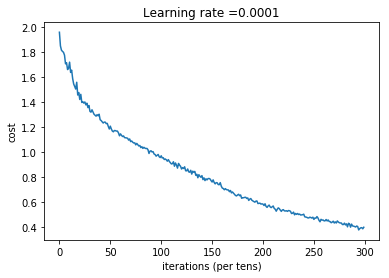

Parameters have been trained!
Train Accuracy: 0.96460176
Test Accuracy: 0.972973


In [469]:
parameters = model(X_train, Y_train, X_test, Y_test)